## Step - 2: Create network of subjects

### Step - 2.1: Create similarity matrix and save to sql.

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm

def subject_AandB(cur,A,B):
    #calculate the number of bills that have both subject A and subject B. Both are strings.
    #query for entires with both subjects.
    query = ("SELECT count(index) FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
                     + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%') AND (subjects LIKE '%%{" + B 
                     +",%%' OR subjects LIKE '%%,"+B+",%%' OR subjects LIKE '%%,"+B+"}%%');")
    cur.execute(query)
    return ((cur.fetchall())[0][0])

def fast_subject_count(cur,A):
    query = ("SELECT count(index) FROM bills WHERE category LIKE 'passage' AND (subjects LIKE '%%{" + A
                     + ",%%' OR subjects LIKE '%%,"+A+",%%' OR subjects LIKE '%%,"+A+"}%%');")
    cur.execute(query)
    return ((cur.fetchall())[0][0])
    
def jaccard_similarity(cur,A,B,nA,nB):
    nAandB = subject_AandB(cur,A,B)
    result = nAandB/(nA+nB-nAandB)
    return result

def get_all_subjects(engine):
    query = "SELECT * FROM topics"
    foo = pd.read_sql_query(query, engine)
    return foo

def clean_subject(a):
    #cleans subject name (a) for use in postgresql query.
    try:
        quoteloc = a.index("'") #may get issues with multiple single quotes in one topic.
        a = a[:quoteloc]+"'"+a[quoteloc:]
    except:
        pass #no quotes found
    #need to add " if there are any spaces in the subject
    try:
        quoteloc = a.index(" ") #will go to except if there are no spaces in the subject
        a = '\"'+a+'\"'
    except:
        pass #no spaces found
    return a

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
conn = psycopg2.connect("dbname='legislatr' user='lordluen' host='localhost'")
cur = conn.cursor()

In [3]:
#visualize bill number cutoff
subs = get_all_subjects(engine)
subs['q_subjects'] = subs['subjects'].map( lambda x: clean_subject(x))
subs['numBills'] = subs['q_subjects'].map( lambda x: fast_subject_count(cur,x))

In [4]:
#plot bill numbers
temp = np.asarray(subs['numBills']) #temporary is a variable I used to store things I don't need to track for long.
temp = np.sort(temp)
tdf = pd.DataFrame() #tdf means temporary dataframe.
tdf['num'] = temp
tdf.head(-1)

,num
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f39e84407b8>]], dtype=object)

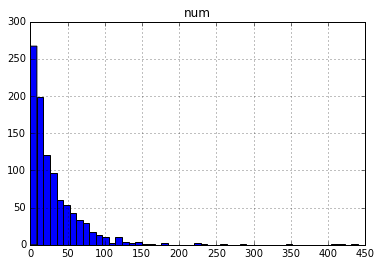

In [5]:
tdf.hist(bins=50)

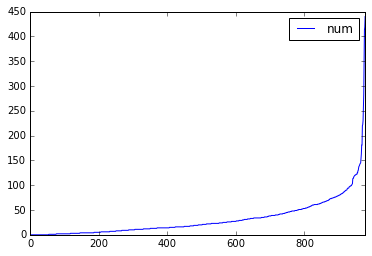

In [6]:
tdf.plot()

In [7]:
#get all subjects
subs = get_all_subjects(engine)
#change syntax to be correct for queries.
subs['q_subjects'] = subs['subjects'].map( lambda x: clean_subject(x))
subs['numBills'] = subs['q_subjects'].map( lambda x: fast_subject_count(cur,x))
#delete subjects that are appear less than 10 times #fairly arbitrary choice.
subs = subs[subs.numBills >= 10]

In [8]:
subs.head(-1)

,index,subjects,q_subjects,numBills
1,1,Abortion,Abortion,40
2,2,Academic performance and assessments,"""Academic performance and assessments""",17
3,3,Access Board,"""Access Board""",13
4,4,Accidents,Accidents,11
5,5,Accounting and auditing,"""Accounting and auditing""",73
7,7,Administrative Conference of the U.S.,"""Administrative Conference of the U.S.""",14
8,8,Administrative law and regulatory procedures,"""Administrative law and regulatory procedures""",284
9,9,Administrative remedies,"""Administrative remedies""",120
10,10,Adoption and foster care,"""Adoption and foster care""",14
13,13,Advanced technology and technological innovations,"""Advanced technology and technological innovat...",48


In [9]:
#dont touch yet...
#save subjects table to sql
sqlCommands.write_to_database(dbname,'subs',subs,engine)

In [23]:
subs_size = subs['subjects'].size
print('subs_size = ',subs_size)
subs_sim = np.zeros((subs_size,subs_size))
for i in tqdm(range(0,subs_size)):
    #print(i)
    a = subs['q_subjects'].iloc[i]
    na = subs['numBills'].iloc[i]
    for j in range(0,subs_size):
        if j < i:
            subs_sim[i,j] = subs_sim[j,i] #matrix is diagonal, so can cut loop time in half.
        else :
            b = subs['q_subjects'].iloc[j]
            nb = subs['numBills'].iloc[j]
            subs_sim[i,j]=jaccard_similarity(cur,a,b,na,nb)
cols = np.arange(subs_size)
rows = np.arange(subs_size)
ss_df = pd.DataFrame(data=subs_sim,index=rows,columns=cols)
sqlCommands.append_to_database(dbname,'subs_sim2',ss_df,engine)

subs_size =  40


100%|██████████| 40/40 [00:09<00:00,  4.01it/s]


In [24]:
ss_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.000000,0.320261,0.311728,0.232198,0.199052,0.221212,0.238532,0.191176,0.004286,0.453917,...,0.148368,0.277612,0.280802,0.239884,0.200573,0.246988,0.241279,0.188953,0.176638,0.293578
1,0.320261,1.000000,0.279412,0.152709,0.128713,0.177340,0.242268,0.169903,0.000000,0.219321,...,0.155440,0.173333,0.246696,0.157205,0.148649,0.213592,0.211982,0.206897,0.131818,0.295000
2,0.311728,0.279412,1.000000,0.328125,0.218121,0.306533,0.224299,0.316583,0.010830,0.311828,...,0.251282,0.217949,0.381818,0.305936,0.320574,0.302885,0.345972,0.220183,0.189427,0.320755
3,0.232198,0.152709,0.328125,1.000000,0.282443,0.370588,0.151961,0.298343,0.007561,0.256131,...,0.331288,0.387097,0.385000,0.392473,0.431034,0.363128,0.352632,0.213198,0.292553,0.338624
4,0.199052,0.128713,0.218121,0.282443,1.000000,0.353175,0.143333,0.270370,0.023962,0.311060,...,0.274510,0.262069,0.332180,0.400763,0.337079,0.348659,0.258621,0.239286,0.295203,0.271127
5,0.221212,0.177340,0.306533,0.370588,0.353175,1.000000,0.148325,0.379310,0.007491,0.283747,...,0.370370,0.348718,0.402985,0.508571,0.494118,0.353261,0.343590,0.232323,0.450292,0.343750
6,0.238532,0.242268,0.224299,0.151961,0.143333,0.148325,1.000000,0.141509,0.011236,0.225131,...,0.108911,0.183036,0.173554,0.156522,0.190698,0.172897,0.162996,0.144186,0.141553,0.192661
7,0.191176,0.169903,0.316583,0.298343,0.270370,0.379310,0.141509,1.000000,0.000000,0.282192,...,0.309942,0.261905,0.345972,0.378238,0.361702,0.195238,0.375000,0.255102,0.282051,0.220657
8,0.004286,0.000000,0.010830,0.007561,0.023962,0.007491,0.011236,0.000000,1.000000,0.026810,...,0.007722,0.007156,0.003448,0.007143,0.009107,0.007339,0.010791,0.009276,0.011070,0.012704
9,0.453917,0.219321,0.311828,0.256131,0.311060,0.283747,0.225131,0.282192,0.026810,1.000000,...,0.236264,0.272021,0.356383,0.305040,0.309783,0.261905,0.272727,0.222798,0.259259,0.289125


### Step - 2.2: Use similarity matrix to create graph and cluster.

In [1]:
%pylab inline
import pandas as pd
import contributions
import votes
import bills
import sqlCommands
from peoplefinder import PeopleFinder
from operator import attrgetter
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
from tqdm import tqdm
import networkx as nx
from cluster_method import girvan_newman
import itertools
from operator import itemgetter

def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight='weight')
    return max(centrality, key=centrality.get)

def heaviest(G):
    u, v, w = max(G.edges(data='weight'), key=itemgetter(2))
    return (u, v)

Populating the interactive namespace from numpy and matplotlib


In [2]:
#set up postgresql engine
dbname = 'legislatr'
engine = sqlCommands.get_engine(dbname)
conn = psycopg2.connect("dbname='legislatr' user='lordluen' host='localhost'")
cur = conn.cursor()

In [9]:
#load subjects list and matrix of similarities
subs = pd.read_sql_table('subs',engine)
subs_sim = pd.read_sql_table('subs_sim',engine)

In [10]:
subs.head(4)

,level_0,index,subjects,q_subjects,numBills
0,1,1,Abortion,Abortion,40
1,2,2,Academic performance and assessments,"""Academic performance and assessments""",17
2,3,3,Access Board,"""Access Board""",13
3,4,4,Accidents,Accidents,11


In [13]:
subs.describe()

,level_0,index,numBills
count,691.000000,691.000000,691.000000
mean,484.134588,484.134588,43.382055
std,283.220584,283.220584,44.063938
min,1.000000,1.000000,10.000000
25%,237.500000,237.500000,17.000000
50%,486.000000,486.000000,31.000000
75%,725.000000,725.000000,54.000000
max,977.000000,977.000000,440.000000


In [14]:
subs_sim.head(2)

,index,0,1,2,3,4,5,6,7,8,...,681,682,683,684,685,686,687,688,689,690
0,0,1.000000,0.017857,0.104167,0.0,0.141414,0.125000,0.062295,0.088435,0.058824,...,0.16129,0.070175,0.294872,0.220000,0.052632,0.129630,0.0,0.112903,0.050000,0.152174
1,1,0.017857,1.000000,0.000000,0.0,0.058824,0.068966,0.034364,0.014815,0.107143,...,0.00000,0.000000,0.083333,0.055556,0.026667,0.055556,0.0,0.150000,0.052632,0.000000


In [15]:
#load up a graph
G_subs = nx.Graph()
#add nodes to the graph
G_subs.add_nodes_from(subs['subjects'])

In [16]:
sim = subs_sim.iloc[0:,1:]

In [17]:
sim.describe()

,0,1,2,3,4,5,6,7,8,9,...,681,682,683,684,685,686,687,688,689,690
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,0.091731,0.043686,0.107606,0.034352,0.136123,0.183372,0.081234,0.092216,0.046645,0.127388,...,0.092666,0.077037,0.157518,0.143552,0.122379,0.173507,0.063859,0.178242,0.069822,0.175730
std,0.063565,0.062828,0.118076,0.057471,0.080292,0.177226,0.069150,0.065382,0.057153,0.084070,...,0.070720,0.069651,0.095504,0.100908,0.073298,0.149847,0.095526,0.123196,0.066554,0.183279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003279,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.055051,0.000000,0.037116,0.000000,0.076923,0.068966,0.036668,0.051471,0.000000,0.062019,...,0.050180,0.032971,0.083333,0.074547,0.071714,0.066667,0.000000,0.085657,0.030303,0.060606
50%,0.090361,0.031250,0.084746,0.019231,0.129412,0.142857,0.062718,0.083333,0.040404,0.126984,...,0.083333,0.066667,0.153846,0.129032,0.121951,0.144068,0.042105,0.163265,0.061728,0.131313
75%,0.125000,0.064516,0.150342,0.052290,0.185376,0.234492,0.107319,0.124612,0.066667,0.180000,...,0.131579,0.112942,0.216063,0.191899,0.165978,0.230769,0.090909,0.257143,0.095696,0.217708
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
bleh = np.asarray(sim) #bleh here is like foo. Just using it as a temporary variable for some calculations.
bleh = np.sort(bleh.flatten())
print(bleh.size)

477481


In [19]:
bleh_df = pd.DataFrame()
bleh_df['w'] = bleh
subs = subs[subs.numBills >= 10]
bleh_df = bleh_df[bleh_df.w > 0]

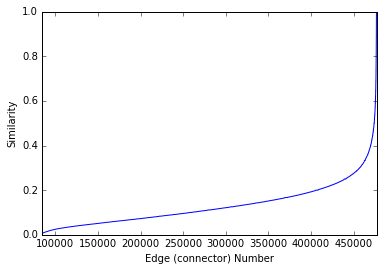

In [20]:
bleh_df.plot(legend=False).set(xlabel="Edge (connector) Number", ylabel="Similarity")

In [21]:
for i in tqdm(range(0,sim['0'].size)):
    for j in range(0,sim['0'].size):
        #loops to add edges. Should be able to drop the j loop, but not sure of proper syntax to greate a list of tuples.
        #would need to use G_subs.add_weighted_edges_from().
        #if weight is infinity, then no edge.
        w = sim[str(i)].iloc[j]
        #only adding edges of weight greater than 0.3 since that is the infleciton point in the plot above.
        if w > 0.3:    
            G_subs.add_edge(subs['subjects'].iloc[i],subs['subjects'].iloc[j],weight=w)

100%|██████████| 691/691 [00:06<00:00, 106.33it/s]


In [22]:
#turn graph to undirected for clustering analysis.
G_subs_ud = G_subs.to_undirected()
G_subs_ud.remove_edges_from(G_subs_ud.selfloop_edges())


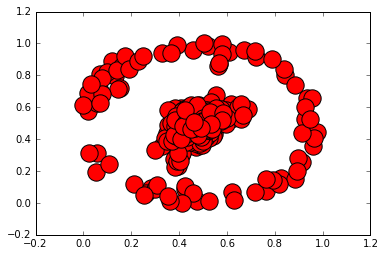

In [23]:
#plot network
pos = nx.spring_layout(G_subs_ud)
nx.draw_networkx_nodes(G_subs_ud,pos,size=10)
nx.draw_networkx_edges(G_subs_ud,pos,width=4)

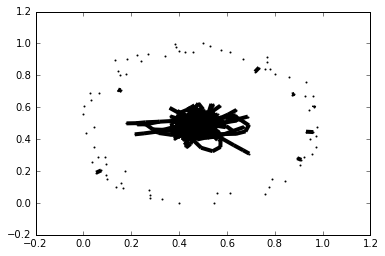

In [24]:
#plot such that edges are easy to see and subject nodes are just dots.
H = G_subs_ud.subgraph(subs['subjects'].iloc[:])
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H,pos,node_size=1)
nx.draw_networkx_edges(H,pos,width=4)

In [26]:
#try futher clustering using girvan_newman.
k = 20
#comp = girvan_newman(G_subs_ud, most_valuable_edge=most_central_edge) #this method is slow with so many subjects.
comp = girvan_newman(G_subs_ud, most_valuable_edge=heaviest) #this is much faster and will prove the same point.
cc = list()
for communities in itertools.islice(comp,k):
    cc.append(tuple(sorted(c) for c in communities))

In [27]:
#plot number of clusters to number of iterations.
niters = np.arange(k)+1
nclusters = np.zeros(k)
for i in range(0,k):
    nclusters[i] = len(cc[i])

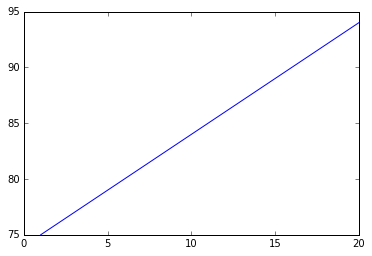

In [28]:
#plot it.
plt.plot(niters,nclusters)

Since a new cluster is formed for each iteration, there are no clusters to be made.

In [29]:
foo = cc[-1]
print(type(foo))
towrite = pd.DataFrame()
towrite['subjects'] = foo

<class 'tuple'>


In [30]:
towrite.head(-1)

,subjects
0,"[Academic performance and assessments, Access ..."
1,[Constitution and constitutional amendments]
2,[Citizenship and naturalization]
3,"[Air quality, Environmental protection]"
4,[Credit and credit markets]
5,[Hospital care]
6,[Government liability]
7,"[Correctional facilities and imprisonment, Fed..."
8,[Judicial review and appeals]
9,[School administration]


In [ ]:
bar = cc[0][1:]
towrite = pd.DataFrame()
towrite['subjects'] = bar
#explantion of naming scheme.
#subs for subjects.
#morebills is the case where I use subjects that were on at least 10 bills.
#hair refers to the subject node hairball in the graphical analysis plot above. Nodes not in the hairball are the cloud.
sqlCommands.write_to_database(dbname,'subs_morebills_hair',towrite,engine)

Step 3 can be found in connect_legislators.ipynb